In [1]:
import numpy as np
import copy

from __future__ import print_function

import time
from PIL import Image

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


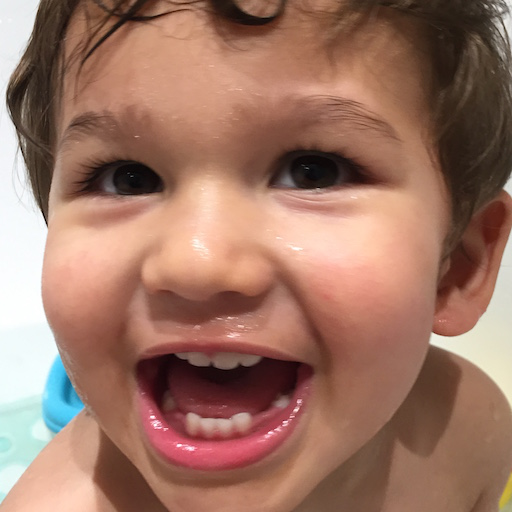

In [2]:
#defining the height and width of the all the three images
image_height = 512
image_width = 512
#loading our content image
content_image_path = 'hugo.jpg'
content_image = Image.open(content_image_path)
#resizeing our content image
content_image = content_image.resize((image_height,image_width))
#printing our content image
content_image



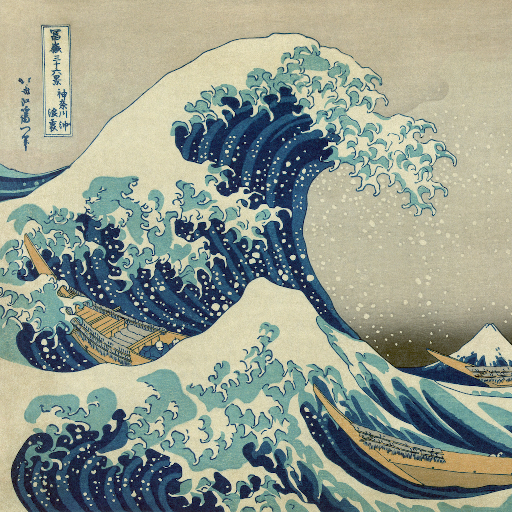

In [3]:

#loading and resize our two style images
style_image_path = 'wave.jpg'
#style_image_path2 = 'picasso.jpg'

style_image = Image.open(style_image_path)
#style_image2 = Image.open(style_image_path2)

style_image = style_image.resize((image_height,image_width))
#style_image2 = style_image2.resize((image_height,image_width))

style_image




In [4]:
#style_image2


In [5]:
#Converting image pixels into numpy array so that computationally suitable
content_array = np.asarray(content_image, dtype='float32')
#here we are adding an extra dimention to the image so that we can concatinate all three images together
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

#Converting image pixels into numpy array so that computationally suitable
style_array = np.asarray(style_image, dtype='float32')
#here we are adding an extra dimention to the image so that we can concatinate all three images together
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

#Converting image pixels into numpy array so that computationally suitable
#style_array2 = np.asarray(style_image2, dtype='float32')
#here we are adding an extra dimention to the image so that we can concatinate all three images together
#style_array2 = np.expand_dims(style_array2, axis=0)
#print(style_array2.shape)


(1, 512, 512, 3)
(1, 512, 512, 3)


<p>Here we will perform two important steps</p>
<ol>
<li>substracting the mean RGB values from each pixel of all the three images</li>
<li>Converting images from RGB to BGR as VGG16 model takes input images in BGR format</li>
</ol>


In [6]:
#substracting mean RGB values from each pixel
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
#Converting RGB to BGR
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

#style_array2[:, :, :, 0] -= 103.939
#style_array2[:, :, :, 1] -= 116.779
#style_array2[:, :, :, 2] -= 123.68
#style_array2 = style_array2[:, :, :, ::-1]



In [7]:
print(content_array.shape)

(1, 512, 512, 3)


In [8]:

#Here we are defining these arrays to the tensorflow variable using keras' backend
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
#style_image2 = backend.variable(style_array2)
#we are declaring a placeholder to store our output later
combination_image = backend.placeholder((1, image_height, image_width, 3))



In [9]:
#here we concatinate our images into a single tensor thats is suitable for processing by keras' vgg16 model 
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

#style_image2

<p>Now we put our tensor into the vvg16 model</p>
<p>vgg16 model is a 16 layer cnn which was prepared by oxford's visual geometry group which won imagnet challenge in 2015</p>
<p>vgg16 file is 500mb file</p>


In [10]:

#here we dont want to classsify our image 
#so we set include_top as false
#which remove vgg16's pooling and fully connected layers
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)



In [11]:
#lokking into different layers of our model
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers





{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

In [12]:
#here we will divide our total loss function into three different parts:
# 1. content loss
# 2. style loss
# 3. total variation loss
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


In [13]:
#initializing total weight with zero adn then we add above weight loss to i
loss=backend.variable(0.)

<h3>Content Loss</h3>

<p>Content loss is determined from the activation of a  trained cnn. Both the output image and base image are run thorough a cnn , which give us a set of features maps for both.the loss at a single layer is the eulidean(L2) distance between trhe activation of the content image and the activations of the output image</p>

In [14]:

#Here we are defining our content  loss function to calculate content loss of our model using keras backend
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

#In this line we are choosing the layer from our model for which we want to calculate our content loss
layer_features = layers['block2_conv2']
#loading activations of the content image
content_image_features = layer_features[0, :, :, :]
#loading activation of the output image
combination_features = layer_features[1, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)



<h3>Style Loss</h3>
<p>Calculating Style loss is litle complex than calculating content loss. First we pass the style image nad output image through a cnn  and observe their activation. But instead of comparing the raw activations directly, we add another step. For both the images we take the Gram matrix of the activations at each layer in the network , the resulting matrix contains the correlation between every pair of feature maps at layer for that image</p>

<p>After calculating Gram matrix ,we can define the single loss at a single layer as the euclidean distance between the Gram matrices of the style and output image</p>

In [15]:

#defining gram martix to calculate style loss
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram



In [16]:

#Calculating the style loss for first style image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = image_height * image_width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#calcuating style for the second style image
#def style_loss2(style1, style2, combination):
 #   S1 = gram_matrix(style1)
  #  S2 = gram_matrix(style2)
   # C = gram_matrix(combination)
  #  channels = 3
   # size =image_height * image_width
   # return backend.sum(backend.square(S1 - C) + backend.square(S2 - C) ) / (4. * (channels ** 2) * (size ** 2))

#selecting layers from which we take acivations
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl



In [17]:
#to minimize noice in the output image
def total_variation_loss(x):
    a = backend.square(x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :])
    b = backend.square(x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [18]:
#Defining gradient to optimaize our combination image

grads = backend.gradients(loss, combination_image)

<p>

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.
</p>

In [21]:

outputs = [loss]
outputs += grads
# Create the function from input combination_img to the loss and gradients
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
        x = x.reshape((1, image_height, image_width, 3))
        outs = f_outputs([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

<p>

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.
</p>

In [22]:
x = np.random.uniform(0, 255, (1, image_height, image_width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 8.80411e+10
Iteration 0 completed in 1108s
Start of iteration 1
Current loss value: 7.38339e+10
Iteration 1 completed in 1151s
Start of iteration 2
Current loss value: 6.98875e+10
Iteration 2 completed in 1358s
Start of iteration 3
Current loss value: 6.85568e+10
Iteration 3 completed in 1212s
Start of iteration 4
Current loss value: 6.80282e+10
Iteration 4 completed in 1146s
Start of iteration 5
Current loss value: 6.77595e+10
Iteration 5 completed in 1117s
Start of iteration 6
Current loss value: 6.75655e+10
Iteration 6 completed in 1098s
Start of iteration 7
Current loss value: 6.74445e+10
Iteration 7 completed in 1098s
Start of iteration 8
Current loss value: 6.73405e+10
Iteration 8 completed in 1196s
Start of iteration 9
Current loss value: 6.72675e+10
Iteration 9 completed in 1228s


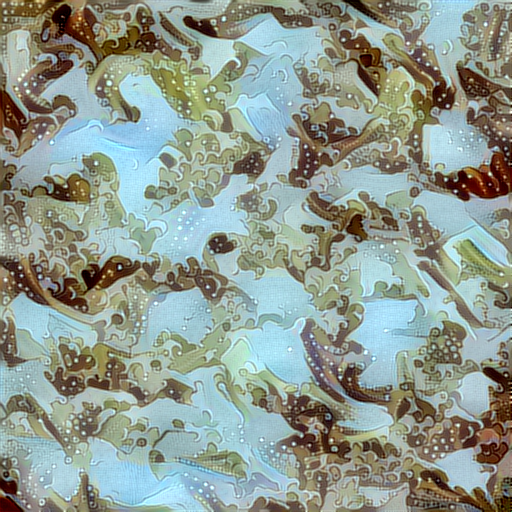

In [32]:
#printing output image
#converting BGR into RGB


x1 = copy.deepcopy(x)
x1 = x1.reshape((image_height,image_width, 3))
# Convert back from BGR to RGB to display the image
x1 = x1[:, :, ::-1]
#x1[:, :, 0] += 103.939
#x1[:, :, 1] += 116.779
#x1[:, :, 2] += 123.68
x1 = np.clip(x1, 0, 255).astype('uint8')
img_final = Image.fromarray(x1)
img_final.save('result' + str(i) + '.bmp')
img_final